исходное изображение


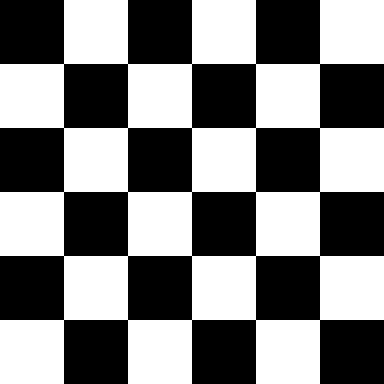

time gpu: 0.3714725971221924
time cpu: 4.637669086456299
ускорение:  12.484552352944574
изображение полученное на gpu:


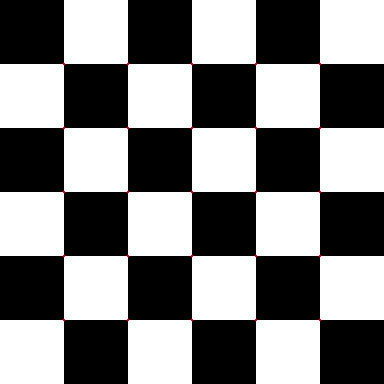

изображение полученное на cpu:


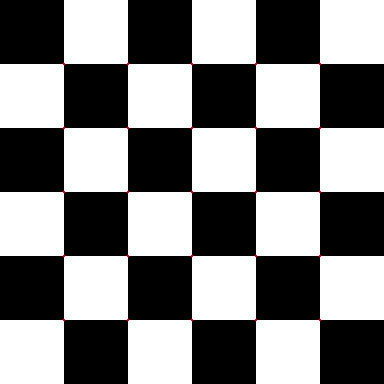

In [61]:
import numpy as np
from numba import cuda
from time import time
import matplotlib.pyplot as plt
import warnings
from PIL import Image
import math
warnings.filterwarnings('ignore')

# расширение изображения (крайние ряды дублируются)
def extend_img(img):
  a = img.copy()
  a = np.vstack((a[0][:], a, a[len(a)-1][:]))
  return np.vstack(np.array([np.hstack((a[i][0], a[i], a[i][len(a[i])-1])) for i in range(len(a))]))

# реализация алгоритма на cpu
def harris_cpu(im):
  mark = np.zeros((im.shape[0], im.shape[1]), dtype=np.int16)
  start = time()
  for i in range(1,im.shape[0]-1):
    for j in range(1, im.shape[1]-1):
      # вычисляем используя фильтр собеля
      Ix = im[i-1][j-1]*-1 + im[i-1][j+1]*1 + im[i][j-1]*-2 + im[i][j+1]*2 + im[i+1][j-1]*-1 + im[i+1][j+1]*1
      Iy = im[i-1][j-1]*-1 + im[i-1][j]*-2 + im[i-1][j+1]*-1 + im[i+1][j-1]*1 + im[i+1][j]*2 + im[i+1][j+1]*1
      Ixx = Ix**2
      Iyy = Iy**2
      Ixy = Ix*Iy
      detA = Ixx*Iyy
      traceA = Ixx+Iyy 
      mark[i][j] = detA - 0.05*traceA**2

  return mark, time()-start

# реализация алгоритма на gpu (а - результат, w - ширина, h - высота)
@cuda.jit
def harris_gpu(im, a, w, h):
  i, j = cuda.grid(2)
  if i>0 and j>0 and i<w[0] and j<h[0]:
      Ix = im[i-1][j-1]*-1 + im[i-1][j+1]*1 + im[i][j-1]*-2 + im[i][j+1]*2 + im[i+1][j-1]*-1 + im[i+1][j+1]*1
      Iy = im[i-1][j-1]*-1 + im[i-1][j]*-2 + im[i-1][j+1]*-1 + im[i+1][j-1]*1 + im[i+1][j]*2 + im[i+1][j+1]*1
      Ixx = Ix**2
      Iyy = Iy**2
      Ixy = Ix*Iy
      detA = Ixx*Iyy
      traceA = Ixx+Iyy 
      a[i][j] = detA - 0.05*traceA**2

# запуск gpu
def exec_gpu(im, im_src):
  # ширина и высота изображения
  w = im.shape[0]
  h = im.shape[1]
  # массиво под результат
  a = np.zeros((w, h), dtype=np.int16)
  # копируем на девайс все нужные данные
  a_global = cuda.to_device(a)
  im_global = cuda.to_device(im)
  w_global = cuda.to_device(w)
  h_global = cuda.to_device(h)
  # задаем сетку
  blok = (32, 32)
  grid = (int(math.ceil(w/blok[0])), int(math.ceil(h/blok[1])))

  start = time()
  harris_gpu[grid, blok](im_global, a_global, w_global, h_global)
  end = time()-start

  mark = a_global.copy_to_host()
  # st = otm(np.array(im_src), im, a, im.shape[0], im.shape[1])
  # display(Image.fromarray(np.uint8(st)).resize((2000, 2000)))
  return mark, end
  
# отрисовка точек углов
def draw_angle(im, mark):
  #исходное изображение
  a = im.copy()
  for i in range(1, mark.shape[0]-1):
    for j in range(1, mark.shape[1]-1):
      # определяем локальные максимумы и перекрашиваем подходящие пикселы в красный цвет
      if mark[i][j]>0:
        t = mark[i][j]
        if mark[i-1][j] <= t and mark[i+1][j]<= t and mark[i][j-1] <= t and mark[i][j+1] <= t:
          a[i-1][j-1] = [255,0,0]
  return a

def experiment(img_name):
  #исходное
  im_src=(Image.open(img_name)).convert('RGB')
  print('исходное изображение')
  display(im_src)
  #в оттенках серого
  im = im_src.convert('L')
  
  # расширяем изображение (копируем крайние ряды пикселов)
  img_array = np.array(im)
  ex_im = extend_img(img_array)
  # запуск на gpu
  res_gpu, time_gpu = exec_gpu(ex_im, im_src)
  res_gpu_img = Image.fromarray(np.uint8(draw_angle(np.array(im_src), res_gpu)))

  # запуск на cpu
  res_cpu, time_cpu = harris_cpu(ex_im)
  res_cpu_img = Image.fromarray(np.uint8(draw_angle(np.array(im_src), res_cpu)))
  
  print('time gpu:', time_gpu)
  print('time cpu:', time_cpu)
  print('ускорение: ', time_cpu/time_gpu)

  print('изображение полученное на gpu:')
  display(res_gpu_img)
  print('изображение полученное на cpu:')
  display(res_cpu_img)

  # сохраняем изображения
  res_gpu_img.save('gpu_'+img_name)
  res_cpu_img.save('cpu_'+img_name)
  

# experiment('out.jpg')
experiment('5.png')